In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

def load(image_path):
    return io.imread(image_path).astype(np.float64) / 255

def display(img):
    # Show image
    plt.figure(figsize = (20,20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


The goal of this project is to implement seam carving to remove "seams" of pixels from an image to make it fit a certain resolution or aspect ratio. A potential application of this would be if a Minecraft screenshot was taken on an ultrawide monitor (simulated by just making the window wide) but needed to be converted to a 16:9 aspect ratio for normal viewing without losing information or adding black bars.

I will use a screenshots to test and demonstrate my code: ultrawide.png in 3:1, to be compared with normal.png in 16:9. 

ultrawide.png is 2880x960
normal.png is 1708x960

The goal is to use seam carving to make ultrawide be a normal 16:9 resolution.

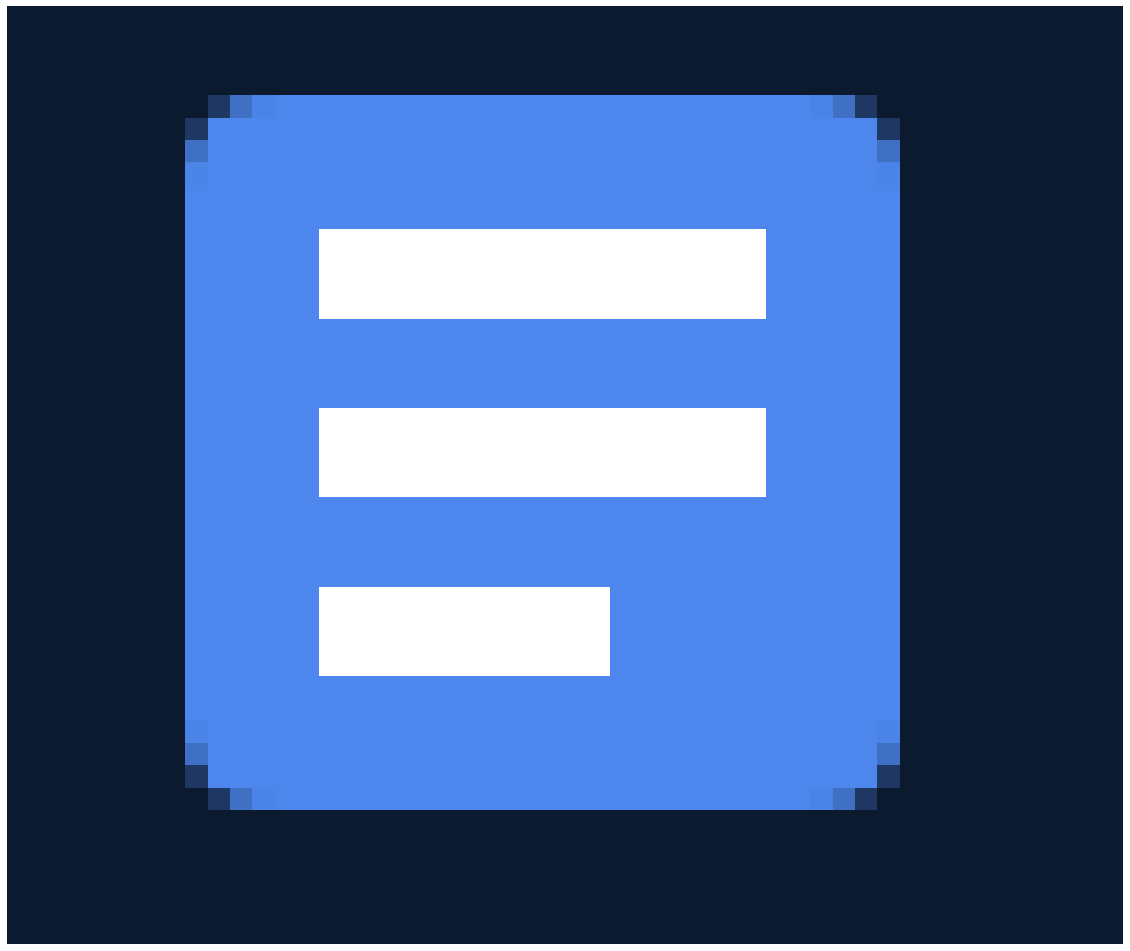

(42, 50, 4)


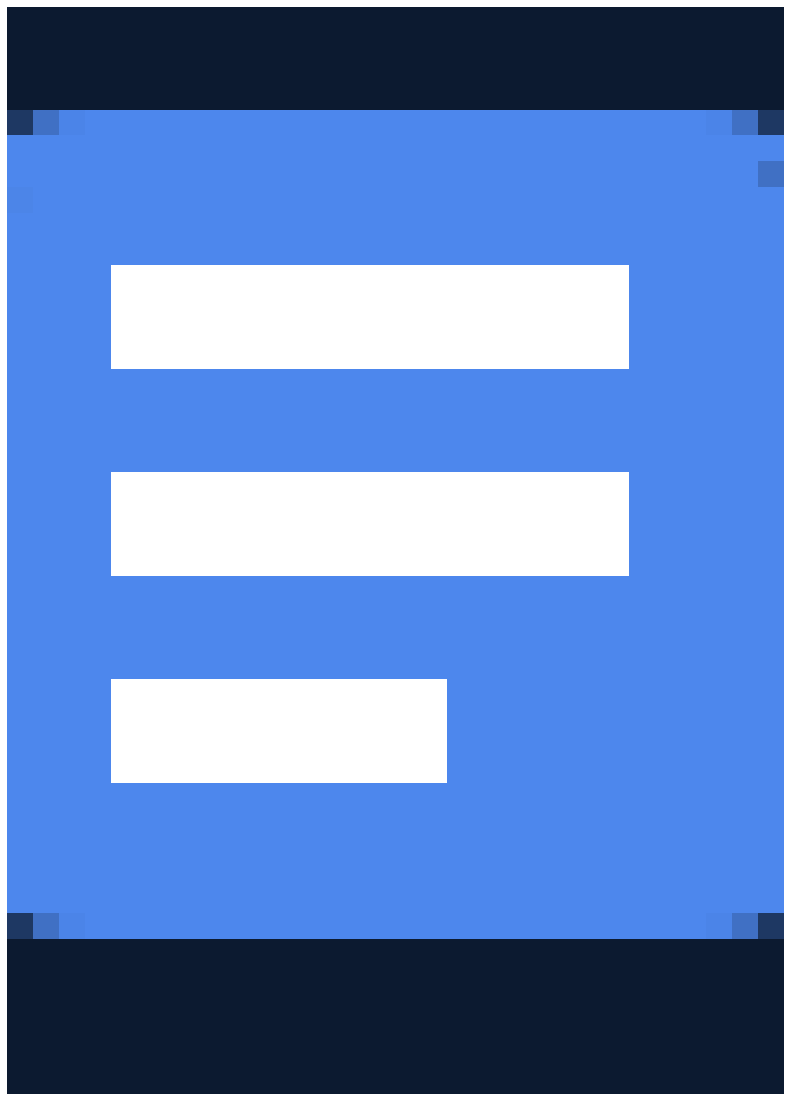

(42, 30, 4)


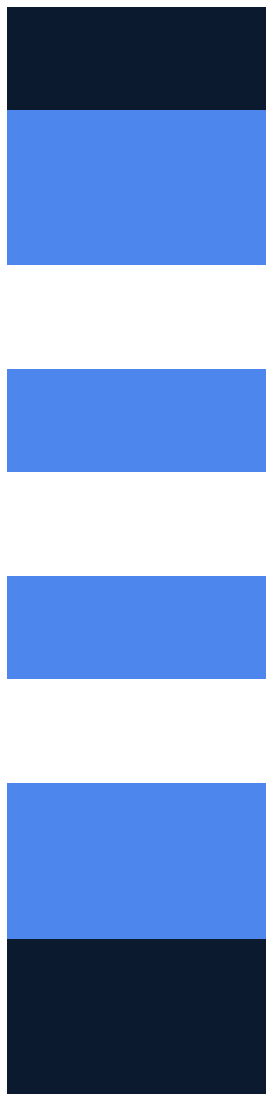

(42, 10, 4)


In [2]:
# I followed https://en.wikipedia.org/wiki/Seam_carving as a reference

# step 1: calculate the magnitude of each pixel using a sobel filter
# the magnitude is referred to as the "energy of each pixel"
# we don't need to normalize here because our images are the exact same but normalization IS a good idea
def mag(img):
    kernel_size = 5
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    mag4d = cv2.cartToPolar(sobel_x, sobel_y)[0] # 0 is mag, 1 is dir
    # don't care about alpha channel but will average the rest
    mags2d = np.zeros((len(img), len(img[0])))
    for i_y, y in enumerate(img):
        for i_x, x in enumerate(y):
            mags2d[i_y][i_x] = np.mean(x[0:3])
    return mags2d
# step 2: use dYnaMIc PrOGrAMMinG to find seams and rank by lowest energy

# iteratively calculate the energy of each pixel by adding its energy to the lowest energy of the 3 closest pixels in the above row
# the top row has no above row so we don't add anything to it
# once the bottom row of energies is known, climb back up using minimum energies
def find_and_remove_one_seam(img):
    mags = mag(img)
    energy = np.zeros((len(img), len(img[0])))

    for i_y, y in enumerate(img):
        for i_x, x in enumerate(y):
            if i_y == 0:
                energy[i_y][i_x] = mags[i_y][i_x]
                
            else:
                # the article appears to only use two for edge cases
                if i_x == 0:
                    energy[i_y][i_x] = mags[i_y][i_x] + np.min([mags[i_y - 1][i_x], 
                                                               mags[i_y - 1][i_x + 1]])

                elif i_x == len(img[0]) - 1:
                    energy[i_y][i_x] = mags[i_y][i_x] + np.min([mags[i_y - 1][i_x - 1],
                                                           mags[i_y - 1][i_x]])

                else:
                    energy[i_y][i_x] = mags[i_y][i_x] + np.min([mags[i_y - 1][i_x - 1],
                                                           mags[i_y - 1][i_x], mags[i_y - 1][i_x + 1]])
    
    # now that we have the energy at each point, we need to start find and remove seams
    # to find and remove a seam:
    # 1: start with the lowest energy at the bottom, remove it      
    # 2: then find and remove the lowest energy pixel above it, etc
    out_img = np.zeros((len(img), len(img[0]) - 1, 4))
    for i_y in range(len(img) - 1, -1, -1):
        remove_idx = np.where(energy[i_y] == min(energy[i_y]))[0][0]
        out_img[i_y] = np.delete(img[i_y], remove_idx, 0)
        
    return out_img
    
wide = load('ultrawide.png')
normal = load('normal.png')

# lets try removing 10 seams from a small sample image (runs fast):
sample = load('sample.png')

display(sample)
print(sample.shape)

for i in range(0,20):
    sample = find_and_remove_one_seam(sample)
    
display(sample)
print(sample.shape)

sample = load('sample.png')

for i in range(0,40):
    sample = find_and_remove_one_seam(sample)
    
display(sample)
print(sample.shape)

# I would call these results pretty good, looks like its working!

original wide:


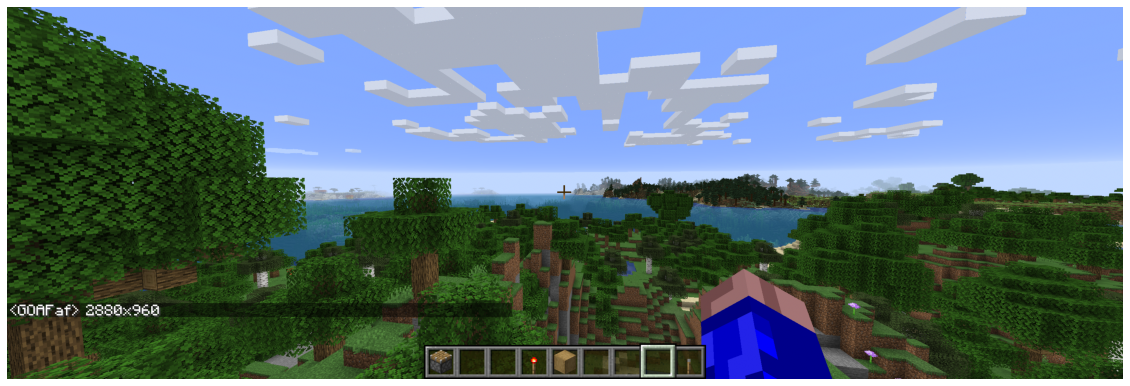

original normal:


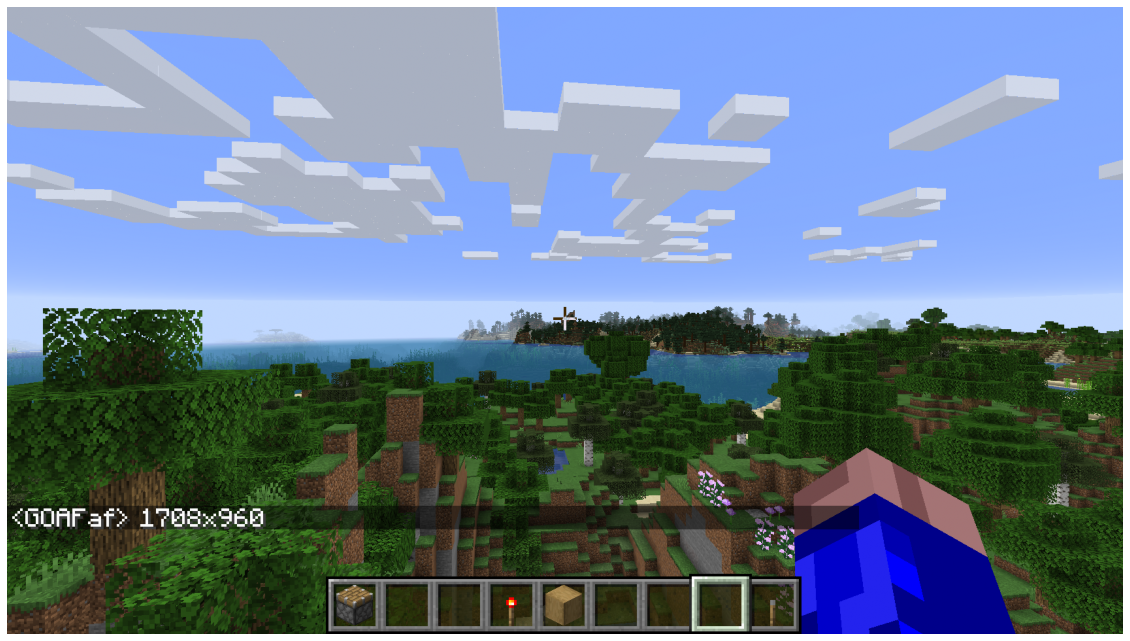

carved wide:


In [ ]:
def seam_carve(img, seam_count):
    for i in range(0,seam_count):
        img = find_and_remove_one_seam(img)
    return img

# lets try our original goal!

width_diff = wide.shape[1] - normal.shape[1]

print("original wide:")
display(wide)

print("original normal:")
display(normal)

print("carved wide:")
display(seam_carve(wide, width_diff))